# Vertex-space correlations

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix

In [2]:
preds = pd.read_csv('../results/validation/target-emotion_preds.tsv', sep='\t', index_col=0)
emotions = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise']

15
(0.5794830918649195, 0.023574424202644467)
15
(0.253065591094124, 0.36280730473798295)


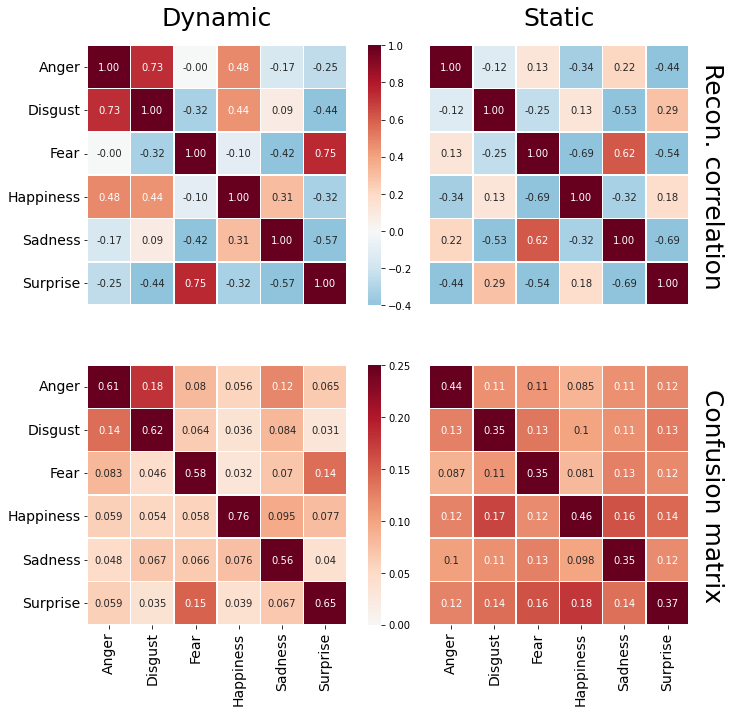

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
for i, tpe in enumerate(['dynamic', 'static']):
    with np.load(f'../results/validation/target-emotion_type-{tpe}_recon.npz') as data:
        S_emo = data['S']
        overlay_emo = data['overlay']

    S_emo_corr = np.corrcoef(S_emo.reshape((6, -1)))
    cbar = True if i == 0 else False
    axes[0, i] = sns.heatmap(
        S_emo_corr, cmap='RdBu_r', annot=True, fmt=".2f", linewidths=.5,
        square=True, ax=axes[0, i], cbar=cbar,# cbar_kws={"shrink": 0.2, "orientation": "horizontal"},
        vmin=-.4, vmax=1, center=0
    )

    axes[0, 0].set_yticklabels(emotions, fontdict={'verticalalignment': 'center', 'size': 14, 'rotation': 0})
    axes[0, i].set_xticks([])
    if i == 1:
        axes[0, i].set_yticks([])

    preds_ = preds.query(f"feature_set == 'vertexPCA_type-{tpe}'")
    cms = np.zeros((13, 6, 6))
    for ii, sub in enumerate(preds['sub'].unique()):
        dat = preds_.query("sub == @sub")
        y_pred = dat.iloc[:, :6].to_numpy().argmax(axis=1)
        y_true = dat['y_true'].to_numpy()
        cms[ii, :, :] = confusion_matrix(y_true, y_pred)

    cm = (cms / cms.sum(axis=1, keepdims=True)).mean(axis=0)
    axes[1, i] = sns.heatmap(cm, ax=axes[1, i], cbar=cbar, square=True, annot=True, linewidths=.5, cmap='RdBu_r',
                             center=0, vmax=0.25, vmin=0)
    if i == 0:
        axes[1, i].set_yticklabels(emotions, fontdict={'verticalalignment': 'center', 'size': 14, 'rotation': 0})
    else:
        axes[1, i].set_yticks([])

    axes[1, i].set_xticklabels(emotions, fontdict={'horizontalalignment': 'center', 'size': 14, 'rotation': 90})
    axes[0, i].set_title(tpe.capitalize(), fontsize=25, pad=20)

    idx = np.triu_indices_from(cm, k=1)
    print(len(idx[0]))
    corr = pearsonr(cm[idx], S_emo_corr[idx])
    print(corr)

axes[0, 1].text(6.25, 3, 'Recon. correlation', va='center', rotation=270, fontsize=25)
axes[1, 1].text(6.25, 3, 'Confusion matrix', va='center', rotation=270, fontsize=25)
fig.tight_layout(w_pad=-5, h_pad=5)

In [4]:
recon = {}
for aff in ['emotion', 'valence', 'arousal']:
    recon[aff] = {}
    for tpe in ['dynamic', 'static']:
        recon[aff][tpe] = {}
        with np.load(f'../results/validation/target-{aff}_type-{tpe}_recon.npz') as data:
            recon[aff][tpe]['S'] = data['S']
            recon[aff][tpe]['overlay'] = data['overlay']

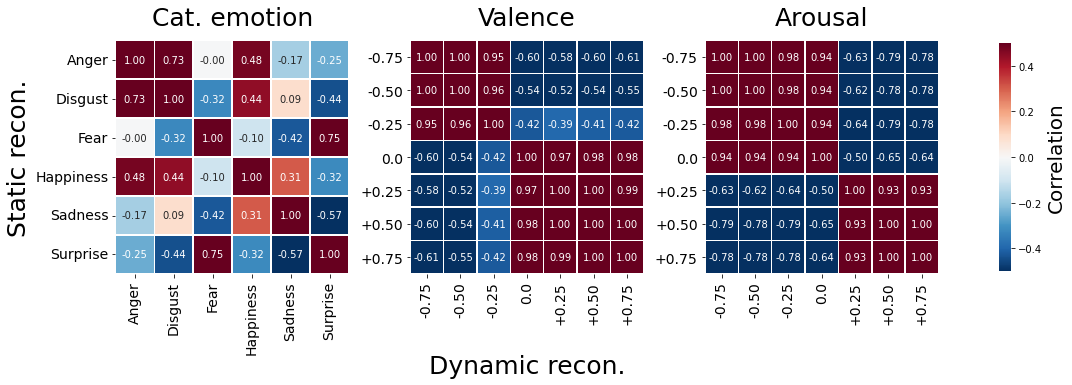

In [8]:
fig, axes = plt.subplots(ncols=4, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1, 0.05]})
for i, aff in enumerate(['emotion', 'valence', 'arousal']):
    stat = recon[aff]['static']['S']
    dyn = recon[aff]['dynamic']['S']
    corr_mat = np.zeros((stat.shape[0], stat.shape[0]))
    for j in range(corr_mat.shape[0]):
        for k in range(corr_mat.shape[0]):
            corr_mat[j, k] = pearsonr(stat[j, :, :].ravel(), dyn[k, :, :].ravel())[0]

    corr_mat = np.corrcoef(dyn.reshape((dyn.shape[0], -1)))
    cbar = True if i == 2 else False
    ax = sns.heatmap(corr_mat, cmap='RdBu_r', vmax=.5, vmin=-.5, center=0, cbar=cbar, cbar_ax=axes[-1],
                     square=True, linewidths=.5, annot=True, fmt='.2f', ax=axes[i])

axes[-1].set_aspect(19.5)
axes[-1].set_ylabel('Correlation', fontsize=20)
axes[0].set_yticklabels(emotions, fontdict={'verticalalignment': 'center', 'size': 14, 'rotation': 0})
axes[0].set_xticklabels(emotions, fontdict={'horizontalalignment': 'center', 'size': 14, 'rotation': 90})
axes[0].set_title("Cat. emotion", fontsize=25, pad=15)
for i, tpe in enumerate(['Valence', 'Arousal']):
    axes[i+1].set_xticklabels(['-0.75', '-0.50', '-0.25', '0.0', '+0.25', '+0.50', '+0.75'],
                              fontdict={'horizontalalignment': 'center', 'size': 14, 'rotation': 90})
    axes[i+1].set_yticklabels(['-0.75', '-0.50', '-0.25', '0.0', '+0.25', '+0.50', '+0.75'],
                              fontdict={'size': 14, 'rotation': 0})
    axes[i+1].set_title(tpe, fontsize=25, pad=15)

axes[0].set_ylabel('Static recon.', fontsize=25)
axes[1].set_xlabel('Dynamic recon.', fontsize=25, labelpad=30)
fig.tight_layout()